In [2]:
# import packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols, glm
import scipy.stats
from statsmodels.api import families

In [3]:
# set directory
main_directory = os.getcwd().strip('notebooks')

## Property internal features analysis 

In this Section we will be examining the correlation of property internal features, such as property type, number of beds/baths/parking to the rental price of the properties. Relevant features will be selected for modelling in the next stage

In [4]:
# read in cleaned rental properties
rental_data_raw =pd.read_csv(main_directory+'data/curated/rental_properties_cleaned.csv')

In [5]:
# only want residential properties
rental_data_raw = rental_data_raw[(rental_data_raw['property_type'] != 'storage unit') &(rental_data_raw['property_type'] != 'Carspace')]

In [6]:
# drop irrelevant columns
rental_data = rental_data_raw.copy()
rental_data.drop(columns = ['Unnamed: 0.1', 'name'], inplace = True)

In [7]:
# rental_data

In [8]:
# factorize certain columns
rental_data.share_flag = rental_data.share_flag.astype('category')

In [9]:
# examine the correlation between the internal attributes of rental property; numerical

corr = rental_data.corr()
# corr.style.background_gradient(cmap='coolwarm')


In [10]:
corr.drop(columns = 'index', inplace = True)

In [11]:
corr.drop('index', inplace = True)

In [12]:
corr.rename(columns = {'cost_text': 'rent cost', 'beds': 'Number of bedrooms', 'baths': 'Number of bathrooms', 'parking': 'Number of parking'},inplace = True)

Many of the features appear to be highly correlated with one another and not correlated with the response variable, we will drop all of these

In [13]:
# many of the features are correlated, we will drop correlated features that also have low correlation with response variable
rental_data.drop(columns = ['beds', 'parking', 'under 20 (%)', '20 - 39 (%)', '40 - 59 (%)', '60 +(%)'], inplace = True)

In [14]:
# correlation between categorical atts 
# function borrowed from https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
from scipy.stats import chi2_contingency
import association_metrics as am
# function to calculate cramer's v
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [15]:
# define categorical variables
rental_categorical = rental_data[['share_flag', 'property_type']].astype('category')

In [16]:
# Initialize a CramersV object 
cramers_v = am.CramersV(rental_categorical)
# It will return a pairwise matrix filled with Cramer's V, where 
# columns and index are the categorical variables of the passed     # pandas.DataFrame
cfit = cramers_v.fit().round(2)
# cfit

### Modelling (reduced)

The only features that remain after selection are: property type, share flag and number of bedrooms. We will explore these possible predictors with a few statistical models in this section 

In [17]:
# generate a simple linear model
fit_OLS = ols(
   formula = "cost_text ~ share_flag + property_type + baths", data = rental_data
).fit()

In [18]:
# check the fit of the model
# fit_OLS.summary()

In [19]:
# plot residuals of the models
fig = plt.figure(figsize=(6,3))
headerfont = {'fontname':'Arial', 'fontsize':12}
plt.rcParams['figure.dpi'] = 360 # increase sharpness of chart
plt.gcf().subplots_adjust(bottom=0.15, left = 0.3)
ax = plt.subplot(111)
graph_DO = scipy.stats.probplot(fit_OLS.resid, plot=plt)
plt.savefig('../plots/ptobplot.png')
plt.close()

In [20]:
# residuals show heavy tails, perhaps a negative binomial model is more suitable?
fit_NB= glm(
    formula = "cost_text ~ share_flag + property_type + baths", data = rental_data,
    family=families.NegativeBinomial()
).fit()


In [21]:
# fit_NB.summary()

In [22]:
# perform an anova on the linear regression model
anova_table = sm.stats.anova_lm(fit_OLS)

In [23]:
# from the anova table, it appears that all features selected in this section are significant
# anova_table

This section's analysis and modelling results suggest that the number of baths, property type and whether the property is shared or not is significant to the rental prices of the property. However, it appears that the variables are too simplistic on their own as predictors. Hence we will explore other external factors but retain these three features for our final modelling

## SA2 specific features analysis

In [24]:
# read in all SA2 specific features
SA2_features_raw = pd.read_csv(main_directory+'data/curated/external_features(SA2).csv')

In [25]:
# replace string values
SA2_features_raw = SA2_features_raw.replace(['np'],'0')

# drop na values
SA2_features_raw.dropna(inplace = True)

In [26]:
# make a copy to look at numerical values
SA2_features = SA2_features_raw.copy()
# drop irrelevant columns
SA2_features.drop(columns = ['pop_2021', 'Unnamed: 0','property_type','LGA code','SA2 code','SA2 name','name'], inplace = True)

In [27]:
# set(SA2_features_raw.property_type) # examine property types

In [28]:
# convert all columns to numerical 
for column in SA2_features.columns:
    # print(column)
    SA2_features[column]=SA2_features[column].astype(float)

In [29]:
# examine the correlation between the internal attributes of rental property; numerical
corr_2 = SA2_features .corr()
corr_2.drop(columns = ['index', 'SA2 code_y', 'SA2 CODE'], inplace = True)
corr_2.drop( ['index', 'SA2 code_y', 'SA2 CODE'], inplace = True)
corr_2.rename(columns = {'cost_text': 'rent price'}, inplace = True)
corr_2.set_index(corr_2.columns, inplace = True)
corr_2.style.background_gradient(cmap='coolwarm')

,rent price,Area,Children_population,Early_Working_age_population,Prime_Working_age_population,Mature_Working_age_population,Elderly_population,2021 crime rate,Median $ 2019,Mean $ 2019
rent price,1.000000,-0.053244,-0.098241,-0.058956,-0.033446,0.023290,-0.032278,0.094645,0.217546,0.285389
Area,-0.053244,1.000000,-0.066948,-0.143209,-0.179730,0.018418,-0.122788,-0.051292,-0.149585,-0.117593
Children_population,-0.098241,-0.066948,1.000000,0.461968,0.612009,0.513033,0.763762,-0.449693,-0.075987,-0.191118
Early_Working_age_population,-0.058956,-0.143209,0.461968,1.000000,0.666602,0.358664,0.719141,0.073924,-0.263296,-0.115203
Prime_Working_age_population,-0.033446,-0.179730,0.612009,0.666602,1.000000,0.377268,0.841241,-0.011264,0.090947,-0.020748
Mature_Working_age_population,0.023290,0.018418,0.513033,0.358664,0.377268,1.000000,0.768916,-0.404294,-0.193024,-0.076746
Elderly_population,-0.032278,-0.122788,0.763762,0.719141,0.841241,0.768916,1.000000,-0.269660,-0.107876,-0.085617
2021 crime rate,0.094645,-0.051292,-0.449693,0.073924,-0.011264,-0.404294,-0.269660,1.000000,0.132043,0.209057
Median $ 2019,0.217546,-0.149585,-0.075987,-0.263296,0.090947,-0.193024,-0.107876,0.132043,1.000000,0.838754
Mean $ 2019,0.285389,-0.117593,-0.191118,-0.115203,-0.020748,-0.076746,-0.085617,0.209057,0.838754,1.000000


Disappointingly, only mean income seem to be moderately correlated with rental prices, so we will only keep this feature for the final modelling

In [30]:
# we will now examine how the SA2 featuers are correlated when it comes to mean and median SA2 rental prices
mean_price = SA2_features_raw.groupby('SA2 name')['cost_text'].mean()
median_price = SA2_features_raw.groupby('SA2 name')['cost_text'].median()

In [31]:
# create a new dataframe to get SA2 specific features only
SA2_data = pd.DataFrame()
SA2_data['mean_price'] = mean_price
SA2_data['median_price']=median_price 

# iterate through dataframe and get SA2 features
for column in SA2_features_raw.iloc[[],8:]: 
    # print(column)
    # convert to float
    SA2_features_raw[column] = SA2_features_raw[column].astype(float)
    # get SA2 features
    SA2_data = SA2_data.merge(SA2_features_raw.groupby('SA2 name')[column].first(),how='left', left_index=True, right_index=True)

In [32]:
# SA2_features_raw

In [33]:
# plot correlation matrixes
# examine the correlation between the internal attributes of rental property; numerical
corr_3 = SA2_data.corr()
corr_3 = SA2_features .corr()
corr_3.drop(columns = ['index', 'SA2 code_y', 'SA2 CODE'], inplace = True)
corr_3.drop( ['index', 'SA2 code_y', 'SA2 CODE'], inplace = True)
corr_3.rename(columns = {'cost_text': 'rent price'}, inplace = True)
corr_3.set_index(corr_2.columns, inplace = True)
corr_3.style.background_gradient(cmap='coolwarm')

,rent price,Area,Children_population,Early_Working_age_population,Prime_Working_age_population,Mature_Working_age_population,Elderly_population,2021 crime rate,Median $ 2019,Mean $ 2019
rent price,1.000000,-0.053244,-0.098241,-0.058956,-0.033446,0.023290,-0.032278,0.094645,0.217546,0.285389
Area,-0.053244,1.000000,-0.066948,-0.143209,-0.179730,0.018418,-0.122788,-0.051292,-0.149585,-0.117593
Children_population,-0.098241,-0.066948,1.000000,0.461968,0.612009,0.513033,0.763762,-0.449693,-0.075987,-0.191118
Early_Working_age_population,-0.058956,-0.143209,0.461968,1.000000,0.666602,0.358664,0.719141,0.073924,-0.263296,-0.115203
Prime_Working_age_population,-0.033446,-0.179730,0.612009,0.666602,1.000000,0.377268,0.841241,-0.011264,0.090947,-0.020748
Mature_Working_age_population,0.023290,0.018418,0.513033,0.358664,0.377268,1.000000,0.768916,-0.404294,-0.193024,-0.076746
Elderly_population,-0.032278,-0.122788,0.763762,0.719141,0.841241,0.768916,1.000000,-0.269660,-0.107876,-0.085617
2021 crime rate,0.094645,-0.051292,-0.449693,0.073924,-0.011264,-0.404294,-0.269660,1.000000,0.132043,0.209057
Median $ 2019,0.217546,-0.149585,-0.075987,-0.263296,0.090947,-0.193024,-0.107876,0.132043,1.000000,0.838754
Mean $ 2019,0.285389,-0.117593,-0.191118,-0.115203,-0.020748,-0.076746,-0.085617,0.209057,0.838754,1.000000


In [34]:
SA2_data.columns

Index(['mean_price', 'median_price', 'SA2 code_y', 'pop_2021', 'Area',
       'Children_population', 'Early_Working_age_population',
       'Prime_Working_age_population', 'Mature_Working_age_population',
       'Elderly_population', '2021 crime rate', 'SA2 CODE', 'Median $ 2019',
       'Mean $ 2019'],
      dtype='object')

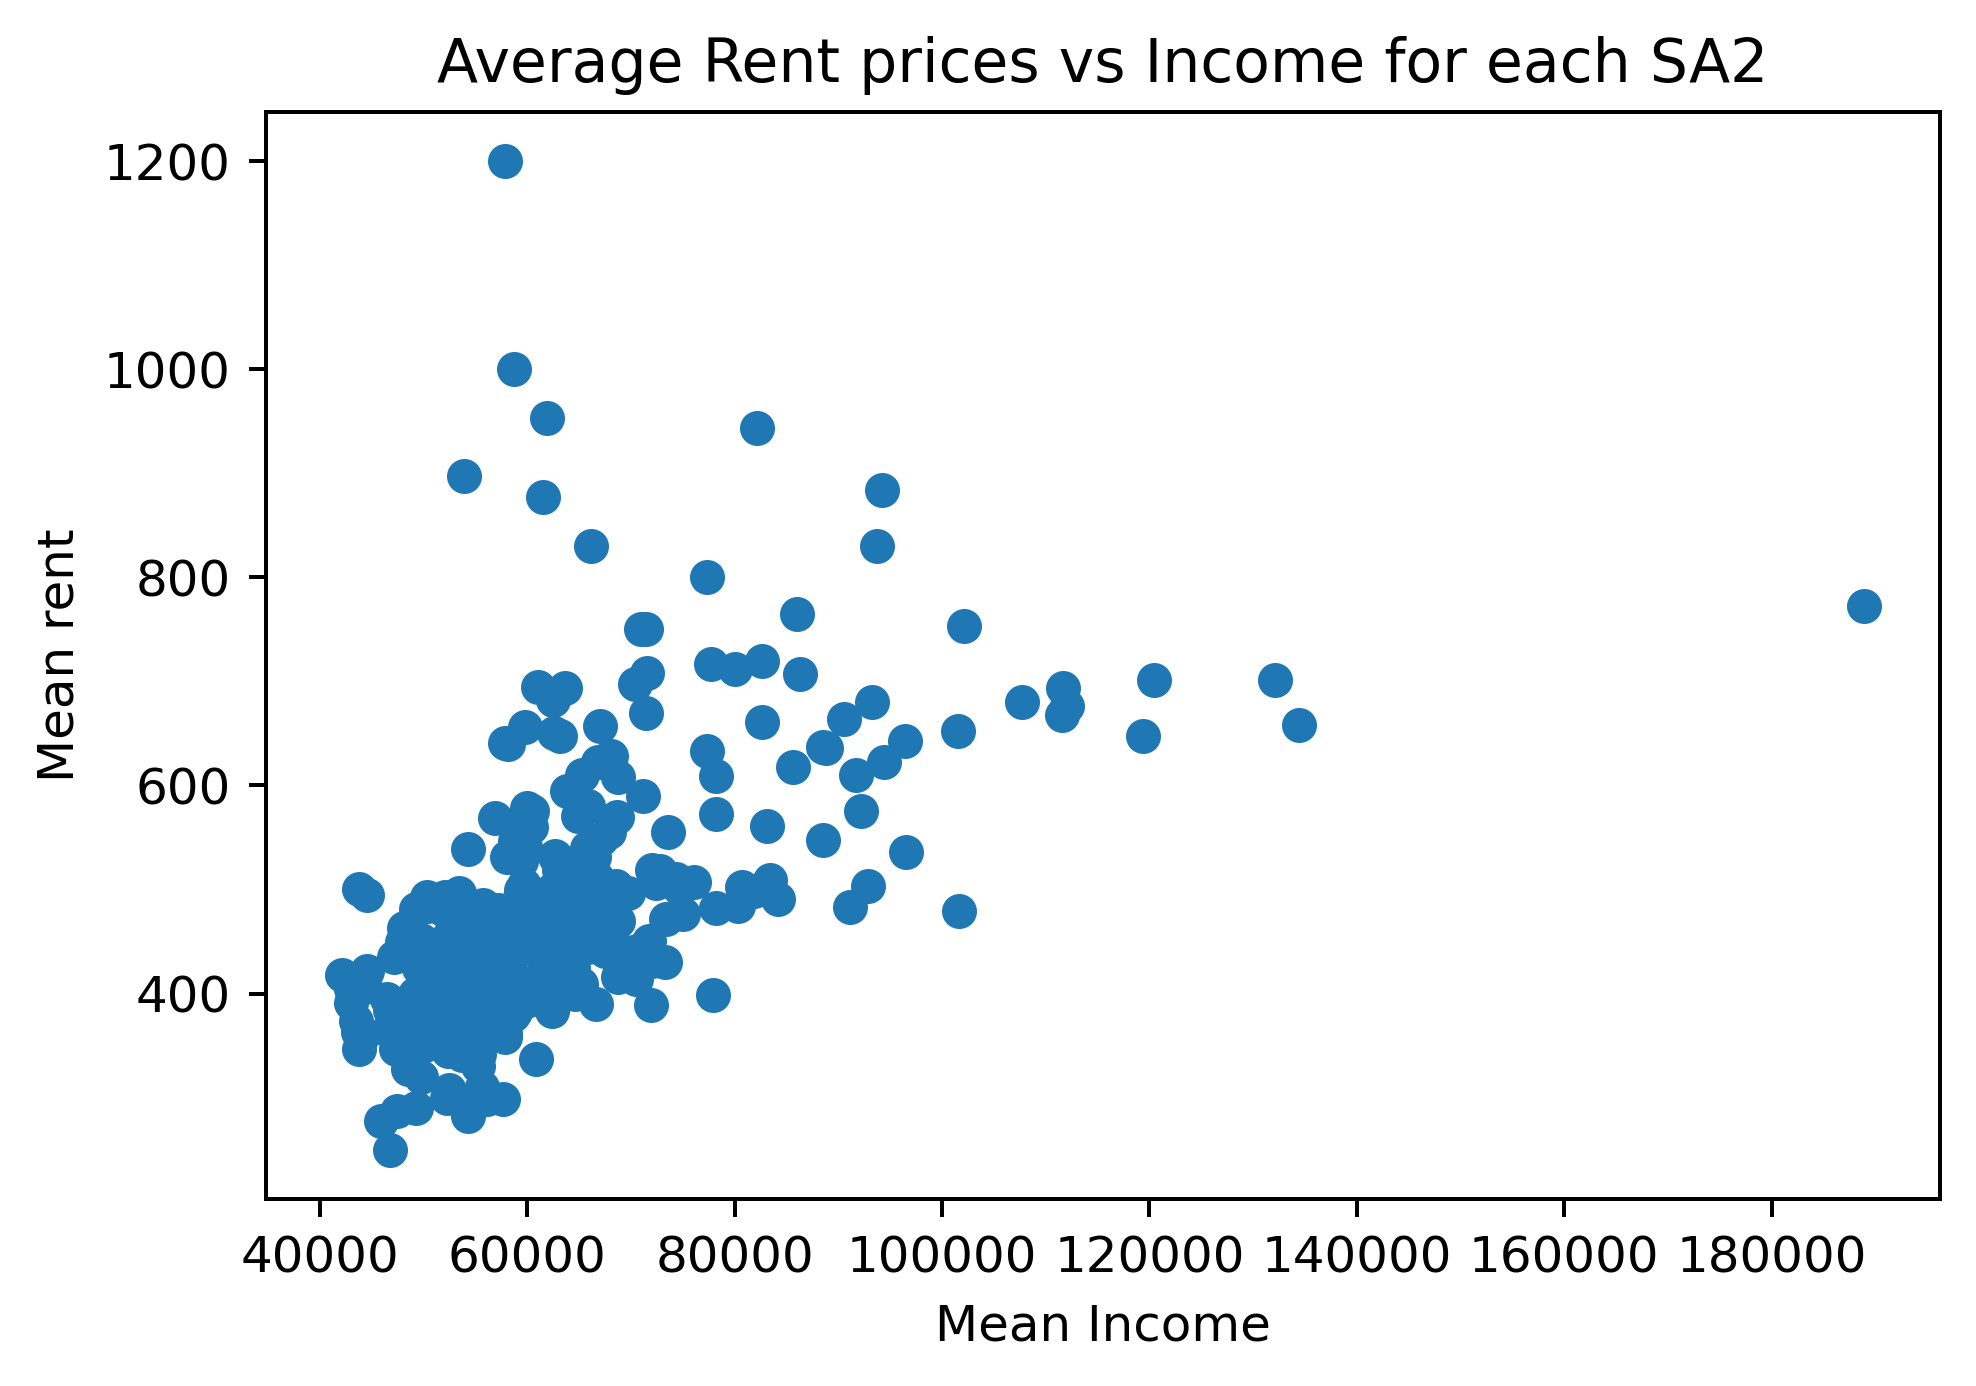

In [35]:
plt.scatter(SA2_data['Mean $ 2019'],SA2_data['mean_price'])
plt.title('Average Rent prices vs Income for each SA2')
plt.xlabel('Mean Income')
plt.ylabel('Mean rent')
plt.savefig(main_directory+'plots/income vs rent.png')

It looks like mean price is highly correlated with the mean SA2 rental prices, we will also potentially fit models with other moderately correlated variables

## POIs analysis

### Preliminaries

In [400]:
from numpy import arange
import matplotlib.pyplot as plt
from itertools import chain
import statsmodels.api as sm
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_validate

In [401]:
# Read in POI counts data
df = pd.read_csv(main_directory+'data/curated/poi_counts.csv',index_col=0)

In [402]:
#dist_df = pd.read_csv(main_directory+'data/curated/POIs/curated/distance.csv',index_col=0)
dist_df = pd.read_csv(main_directory+'data/curated/POIs/POIs/distance.csv',index_col=0)

In [403]:
# dist_df

In [404]:
# Read in category types
with open(main_directory+'/data/curated/poi_types.txt', 'r') as fp:
    ls = fp.read().splitlines()

In [405]:
# df

In [406]:
df_full = pd.concat([df, dist_df], join='inner', ignore_index=True, axis=1).drop(columns=[272])

In [407]:
columns = [['coordinates'], ls, ['cost'], ['distance', 'duration']]
columns = list(chain.from_iterable(columns))

In [408]:
df_full.set_axis(columns, axis=1, inplace=True)

In [409]:
df_full.dropna(inplace=True)

In [410]:
# Reorder the columns
df_full = df_full[chain.from_iterable([['coordinates'],['distance', 'duration'], ls, ['cost']])]

In [411]:
plt.hist(df_full['cost'], bins = 40)
plt.title('Histogram of Distribution of Rental Costs')
plt.savefig(main_directory+'models/cost_hist.png')
plt.close()

In [412]:
plt.boxplot(df_full['cost'])
plt.title('Boxplot of Costs')
plt.savefig(main_directory+'models/cost_boxplot.png')
plt.close()

#### From the 2 plots, we can see that there are a lot of outliers with low costs. They may be associated with the many storage units in listing.

### OLS Regression based on POI

In [413]:
def get_stats():
    df = df_full.drop(['coordinates', 'e-cigarette'], axis=1)
    results = ols(formula='cost ~ ' + " + ".join(list(df.columns)[:-1]), data=df).fit()
    #print(results.summary())
    #print(sm.stats.anova_lm(results))
    return results.summary(), sm.stats.anova_lm(results)

In [414]:
summ, anova = get_stats()

In [415]:
top_features = anova.sort_values('PR(>F)').head(20)

In [416]:
#summ

In [417]:
#top_features.iloc[1:12,]

In [418]:
top_features.to_csv('../data/curated/top_features.csv')

The OLS model has a R^2 of 0.825, which is really good. However, it uses all the features, which loses out on generalisation.

## Liveability

In [563]:
rental_income = SA2_features_raw.merge(rental_data_raw, on = ['name'], how = 'outer')
# drop nas
rental_income.dropna(inplace = True)
rental_income.reset_index(inplace = True)
sa2_rent = rental_income.copy()
sa2_rent = sa2_rent[['coordinates', 'SA2 name']]
df_live = pd.concat([df_full, sa2_rent], join='inner', ignore_index=True, axis=1).drop(columns=274)
columns = chain.from_iterable([['coordinates'],['distance', 'duration'], ls, ['cost'], ['sa2_code']])
df_live.set_axis(columns, axis=1, inplace=True)
gb_live = df_live[['supermarket', 'pitch', 'cafe', 'sa2_code']].groupby('sa2_code').mean().round(2)
live_list = ['supermarket', 'pitch', 'cafe']

supermarket_max = gb_live.max()[0]
pitch_max = gb_live.max()[1]
cafe_max = gb_live.max()[2]

gb_live['supermarket_scaled'] = gb_live['supermarket'] / supermarket_max
gb_live['pitch_scaled'] = gb_live['pitch'] / pitch_max
gb_live['cafe_scaled'] = gb_live['cafe'] / cafe_max
gb_live['liveability'] = gb_live['supermarket_scaled'] + gb_live['pitch_scaled'] + gb_live['cafe_scaled']

gb_live = gb_live.sort_values('liveability', ascending=False).head(10).round(2)
gb_live.to_csv(main_directory+'data/curated/top10_liveable.csv')

In [564]:
gb_live

,supermarket,pitch,cafe,supermarket_scaled,pitch_scaled,cafe_scaled,liveability
sa2_code,,,,,,,
Rutherglen,26.00,98.00,190.00,1.00,0.37,1.00,2.37
Montrose,12.50,265.50,70.50,0.48,1.00,0.37,1.85
Yarram,15.00,219.00,71.00,0.58,0.82,0.37,1.78
Castlemaine,11.25,264.50,65.50,0.43,1.00,0.34,1.77
Alfredton,21.00,74.42,128.84,0.81,0.28,0.68,1.77
East Bendigo - Kennington,20.43,155.86,74.71,0.79,0.59,0.39,1.77
Ballarat,13.71,216.36,70.57,0.53,0.81,0.37,1.71
Seymour,18.00,200.00,10.00,0.69,0.75,0.05,1.50
Daylesford,13.33,141.17,67.50,0.51,0.53,0.36,1.40


### Modelling (reduced)

We now try and fit an elastic net regression model on the data.

#### Perform a grid search through values for alpha and penalty parameters of elastic net to find optimal values.

In [314]:
X, y = df_full.iloc[:,1:-1], df_full.iloc[:,-1]
model = ElasticNet()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=1, random_state=1)
# define grid
grid = dict()
grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
grid['l1_ratio'] = arange(0, 1, 0.1)
# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=2)
# perform the search
results = search.fit(X, y)
# summarize
# print('MAE: %.3f' % results.best_score_)
# print('Config: %s' % results.best_params_)

KeyboardInterrupt: 

### Create the elastic net model with optimal parameters

In [315]:
x = df_full[ls]
y = df_full['cost']
# Scale the columns
scaler = StandardScaler()
df_scaled = scaler.fit_transform(x)
net = ElasticNet(random_state=0, alpha=0.1, l1_ratio=0)
results_cv = cross_validate(net, df_scaled, y, cv=10, n_jobs=2, scoring='r2')
;

/Users/lucyliu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.891e+07, tolerance: 6.890e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/lucyliu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.000e+07, tolerance: 4.867e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solv

''

In [312]:
pd.DataFrame(results_cv).to_json(main_directory +'data/curated/CVresultsEnet.csv')

In [313]:
# results_cv['test_score']

We can see that the variance of the R^2 value across the validation runs is very high.

In [314]:
net.fit(df_scaled,y);

/Users/lucyliu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.198e+07, tolerance: 7.634e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


In [101]:
coefs = net.coef_
remove_list = []
for i in range(len(coefs)):
    if abs(coefs[i]) < 0.05:
        remove_list.append(ls[i])

In [102]:
# remove_list

In [103]:
len(remove_list)

5

In [104]:
columns = list(chain.from_iterable([['coordinates'], ['distance', 'duration'],ls]))

In [105]:
df_reduce = df_full[columns].drop(remove_list, axis=1)

In [106]:
df_unique = pd.DataFrame(df_reduce.nunique(), columns=['Counts'])

In [107]:
# df_unique[df_unique['Counts'] <= 5]

#### There are quite a lot of features with few unique values. Most of these could be noise to the data, and will need to be filtered out.

In [108]:
remove_list = list(df_unique[df_unique['Counts'] <= 5].index)

In [109]:
df_reduce = df_reduce.drop(remove_list, axis=1)

In [110]:
# df_reduce

In [111]:
# For further testing if required
#df_unique2 = pd.DataFrame(df_reduce.nunique(), columns=['Counts'])

In [112]:
df_reduce.to_csv(main_directory+'data/curated/reduced_POI_optimal_v2.csv')

In [ ]:
# df_reduce

## most affordable suburb analysis

In [553]:
## concatenate income and rental info data
rental_income = SA2_features_raw.merge(rental_data_raw, on = ['name'])

In [554]:
# drop nas
rental_income.dropna(inplace = True)
rental_income.reset_index(inplace = True)

In [555]:
# get column for affordability ratio
ratios = []
# if shared, only count as one person renting it
for i in range(len(rental_income)): 
    if rental_income['share_flag'][i] == 1 or rental_income['beds'][i]==0: 
        ratios.append(rental_income['cost_text_x'][i]/((rental_income['Mean $ 2019'][i])/52))
    else:
        ratios.append(rental_income['cost_text_x'][i]/((rental_income['Mean $ 2019'][i]* rental_income['beds'][i])/52))
          
    


In [556]:
# groupby SA2 and get affordability ratio
rental_income['affordability ratio'] = ratios

In [557]:
rental_income['affordability ratio'] = rental_income['affordability ratio'].astype(float) # convert to float

In [558]:
# get average affordability ratio in each suburb
average_aff_ratios = rental_income.groupby('SA2 name')['affordability ratio'].mean()

In [559]:
average_aff_ratios.sort_values(inplace = True)

In [560]:
rental_income

,index,Unnamed: 0_x,index_x,name,LGA code,SA2 code,cost_text_x,property_type_x,SA2 name,SA2 code_y,...,desc,beds,baths,parking,under 20 (%),20 - 39 (%),40 - 59 (%),60 +(%),share_flag,affordability ratio
0,0,0,3531.0,20 Adrianus Street Alfredton VIC 3350,Ballarat,201011001,460.0,House,Alfredton,201011001.0,...,offering abundance class style excellent four ...,4,2,2,29.0,39.0,23.0,9.0,0,0.093925
1,1,1,2993.0,66 Lugano Avenue Alfredton VIC 3350,Ballarat,201011001,440.0,House,Alfredton,201011001.0,...,"book inspection online 24/7, click ""book inspe...",4,2,2,29.0,39.0,23.0,9.0,0,0.089841
2,2,2,2924.0,15 Nyon Road Alfredton VIC 3350,Ballarat,201011001,430.0,House,Alfredton,201011001.0,...,prd express approval property - inspect proper...,3,2,2,29.0,39.0,23.0,9.0,0,0.117066
3,3,3,3589.0,33 Walters Way Alfredton VIC 3350,Ballarat,201011001,460.0,House,Alfredton,201011001.0,...,brand new spacious home one miss. landscaping ...,4,2,2,29.0,39.0,23.0,9.0,0,0.093925
4,4,4,2953.0,52 Vale Street Alfredton VIC 3350,Ballarat,201011001,440.0,House,Alfredton,201011001.0,...,"enviable lifestyle able walk schools, shops, l...",3,2,2,19.0,36.0,26.0,20.0,0,0.119788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4299,4301,6641,5407.0,27 Koroit Street Warrnambool VIC 3280,Moyne,217041480,600.0,House,Warrnambool - South,217041480.0,...,"situated within walking distance cbd, home com...",4,3,1,16.0,18.0,28.0,38.0,0,0.133912
4300,4302,6642,123.0,1 Princes Highway Warrnambool VIC 3280,Moyne,217041480,212.0,Studio,Warrnambool - South,217041480.0,...,video links:https://youtu.be/4tjkoj2b6jahttps:...,1,1,0,21.0,20.0,26.0,32.0,1,0.189263
4301,4303,6643,1842.0,449 Raglan Parade Warrnambool VIC 3280,Moyne,217041480,390.0,House,Warrnambool - South,217041480.0,...,move straight little gem comprising:2 bedrooms...,2,1,1,17.0,32.0,26.0,24.0,0,0.174086
4302,4304,6644,1562.0,238A Koroit Street Warrnambool VIC 3280,Moyne,217041480,380.0,House,Warrnambool - South,217041480.0,...,***please apply line alternatively pick applic...,2,1,1,21.0,31.0,25.0,23.0,0,0.169622


## Final modelling (all relevant features)

### OLS model

In [485]:
SA2_data

,mean_price,median_price,SA2 code_y,pop_2021,Area,Children_population,Early_Working_age_population,Prime_Working_age_population,Mature_Working_age_population,Elderly_population,2021 crime rate,SA2 CODE,Median $ 2019,Mean $ 2019
SA2 name,,,,,,,,,,,,,,
Abbotsford,572.679045,575.0,206071139.0,9262.0,1.7,759.0,905.0,6450.0,578.0,9832.0,0.118272,206071139.0,64090.0,78181.0
Airport West,409.000000,400.0,210011226.0,8237.0,3.7,1384.0,762.0,4102.0,797.0,9429.0,0.049673,210011226.0,58506.0,65204.0
Albert Park,700.882353,535.0,206051128.0,16023.0,4.7,2165.0,1470.0,8541.0,1731.0,18139.0,0.098302,206051128.0,67518.0,120412.0
Alexandra,350.000000,350.0,204011054.0,6768.0,2119.0,910.0,531.0,2601.0,1258.0,8236.0,0.043809,204011054.0,39452.0,48414.0
Alfredton,423.421053,420.0,201011001.0,16823.0,52.7,4075.0,2391.0,7550.0,1375.0,18255.0,0.063340,201011001.0,53932.0,63668.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Yarram,327.500000,327.5,205051104.0,5556.0,1931.9,777.0,470.0,2122.0,1098.0,6645.0,0.070800,205051104.0,37232.0,48524.0
Yarraville,560.571429,540.0,213031352.0,15653.0,5.6,3024.0,1439.0,8874.0,1172.0,16797.0,0.081576,213031352.0,69410.0,83130.0
Yarrawonga,451.666667,495.0,216021414.0,8585.0,94.7,1364.0,752.0,2986.0,1367.0,10701.0,0.053705,216021414.0,41980.0,49703.0


In [486]:
# drop irrelevant columns
SA2_data_2 = SA2_data.copy()
SA2_data_2.drop(columns = ['median_price','SA2 code_y', 'SA2 CODE'], inplace = True)

In [487]:
SA2_data_2

,mean_price,pop_2021,Area,Children_population,Early_Working_age_population,Prime_Working_age_population,Mature_Working_age_population,Elderly_population,2021 crime rate,Median $ 2019,Mean $ 2019
SA2 name,,,,,,,,,,,
Abbotsford,572.679045,9262.0,1.7,759.0,905.0,6450.0,578.0,9832.0,0.118272,64090.0,78181.0
Airport West,409.000000,8237.0,3.7,1384.0,762.0,4102.0,797.0,9429.0,0.049673,58506.0,65204.0
Albert Park,700.882353,16023.0,4.7,2165.0,1470.0,8541.0,1731.0,18139.0,0.098302,67518.0,120412.0
Alexandra,350.000000,6768.0,2119.0,910.0,531.0,2601.0,1258.0,8236.0,0.043809,39452.0,48414.0
Alfredton,423.421053,16823.0,52.7,4075.0,2391.0,7550.0,1375.0,18255.0,0.063340,53932.0,63668.0
...,...,...,...,...,...,...,...,...,...,...,...
Yarram,327.500000,5556.0,1931.9,777.0,470.0,2122.0,1098.0,6645.0,0.070800,37232.0,48524.0
Yarraville,560.571429,15653.0,5.6,3024.0,1439.0,8874.0,1172.0,16797.0,0.081576,69410.0,83130.0
Yarrawonga,451.666667,8585.0,94.7,1364.0,752.0,2986.0,1367.0,10701.0,0.053705,41980.0,49703.0


In [488]:
SA2_data_2

,mean_price,pop_2021,Area,Children_population,Early_Working_age_population,Prime_Working_age_population,Mature_Working_age_population,Elderly_population,2021 crime rate,Median $ 2019,Mean $ 2019
SA2 name,,,,,,,,,,,
Abbotsford,572.679045,9262.0,1.7,759.0,905.0,6450.0,578.0,9832.0,0.118272,64090.0,78181.0
Airport West,409.000000,8237.0,3.7,1384.0,762.0,4102.0,797.0,9429.0,0.049673,58506.0,65204.0
Albert Park,700.882353,16023.0,4.7,2165.0,1470.0,8541.0,1731.0,18139.0,0.098302,67518.0,120412.0
Alexandra,350.000000,6768.0,2119.0,910.0,531.0,2601.0,1258.0,8236.0,0.043809,39452.0,48414.0
Alfredton,423.421053,16823.0,52.7,4075.0,2391.0,7550.0,1375.0,18255.0,0.063340,53932.0,63668.0
...,...,...,...,...,...,...,...,...,...,...,...
Yarram,327.500000,5556.0,1931.9,777.0,470.0,2122.0,1098.0,6645.0,0.070800,37232.0,48524.0
Yarraville,560.571429,15653.0,5.6,3024.0,1439.0,8874.0,1172.0,16797.0,0.081576,69410.0,83130.0
Yarrawonga,451.666667,8585.0,94.7,1364.0,752.0,2986.0,1367.0,10701.0,0.053705,41980.0,49703.0


In [489]:
# rename variable so it can be joined
SA2_data_2.rename(columns = {'mean price':'mean_price', 'Median $ 2019': 'Median_income_2019','Mean $ 2019': 'Mean_income_2019', '2021 crime rate': 'crime_rate_2021'}, inplace = True)

In [490]:
# segregate all features columns
features_names = list(SA2_data_2.iloc[[],2:].columns)

In [491]:
features_names

['Area',
 'Children_population',
 'Early_Working_age_population',
 'Prime_Working_age_population',
 'Mature_Working_age_population',
 'Elderly_population',
 'crime_rate_2021',
 'Median_income_2019',
 'Mean_income_2019']

In [492]:
SA2_data

,mean_price,median_price,SA2 code_y,pop_2021,Area,Children_population,Early_Working_age_population,Prime_Working_age_population,Mature_Working_age_population,Elderly_population,2021 crime rate,SA2 CODE,Median $ 2019,Mean $ 2019
SA2 name,,,,,,,,,,,,,,
Abbotsford,572.679045,575.0,206071139.0,9262.0,1.7,759.0,905.0,6450.0,578.0,9832.0,0.118272,206071139.0,64090.0,78181.0
Airport West,409.000000,400.0,210011226.0,8237.0,3.7,1384.0,762.0,4102.0,797.0,9429.0,0.049673,210011226.0,58506.0,65204.0
Albert Park,700.882353,535.0,206051128.0,16023.0,4.7,2165.0,1470.0,8541.0,1731.0,18139.0,0.098302,206051128.0,67518.0,120412.0
Alexandra,350.000000,350.0,204011054.0,6768.0,2119.0,910.0,531.0,2601.0,1258.0,8236.0,0.043809,204011054.0,39452.0,48414.0
Alfredton,423.421053,420.0,201011001.0,16823.0,52.7,4075.0,2391.0,7550.0,1375.0,18255.0,0.063340,201011001.0,53932.0,63668.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Yarram,327.500000,327.5,205051104.0,5556.0,1931.9,777.0,470.0,2122.0,1098.0,6645.0,0.070800,205051104.0,37232.0,48524.0
Yarraville,560.571429,540.0,213031352.0,15653.0,5.6,3024.0,1439.0,8874.0,1172.0,16797.0,0.081576,213031352.0,69410.0,83130.0
Yarrawonga,451.666667,495.0,216021414.0,8585.0,94.7,1364.0,752.0,2986.0,1367.0,10701.0,0.053705,216021414.0,41980.0,49703.0


In [528]:
# generate a simple linear model
OLS_SA2 = ols(
   formula = "mean_price ~ Mean_income_2019", data = SA2_data_2
).fit()

In [529]:
# OLS_SA2.summary() # summarise model fit

In [530]:
# perform anova to assess variables 
anova_table_2 = sm.stats.anova_lm(OLS_SA2)

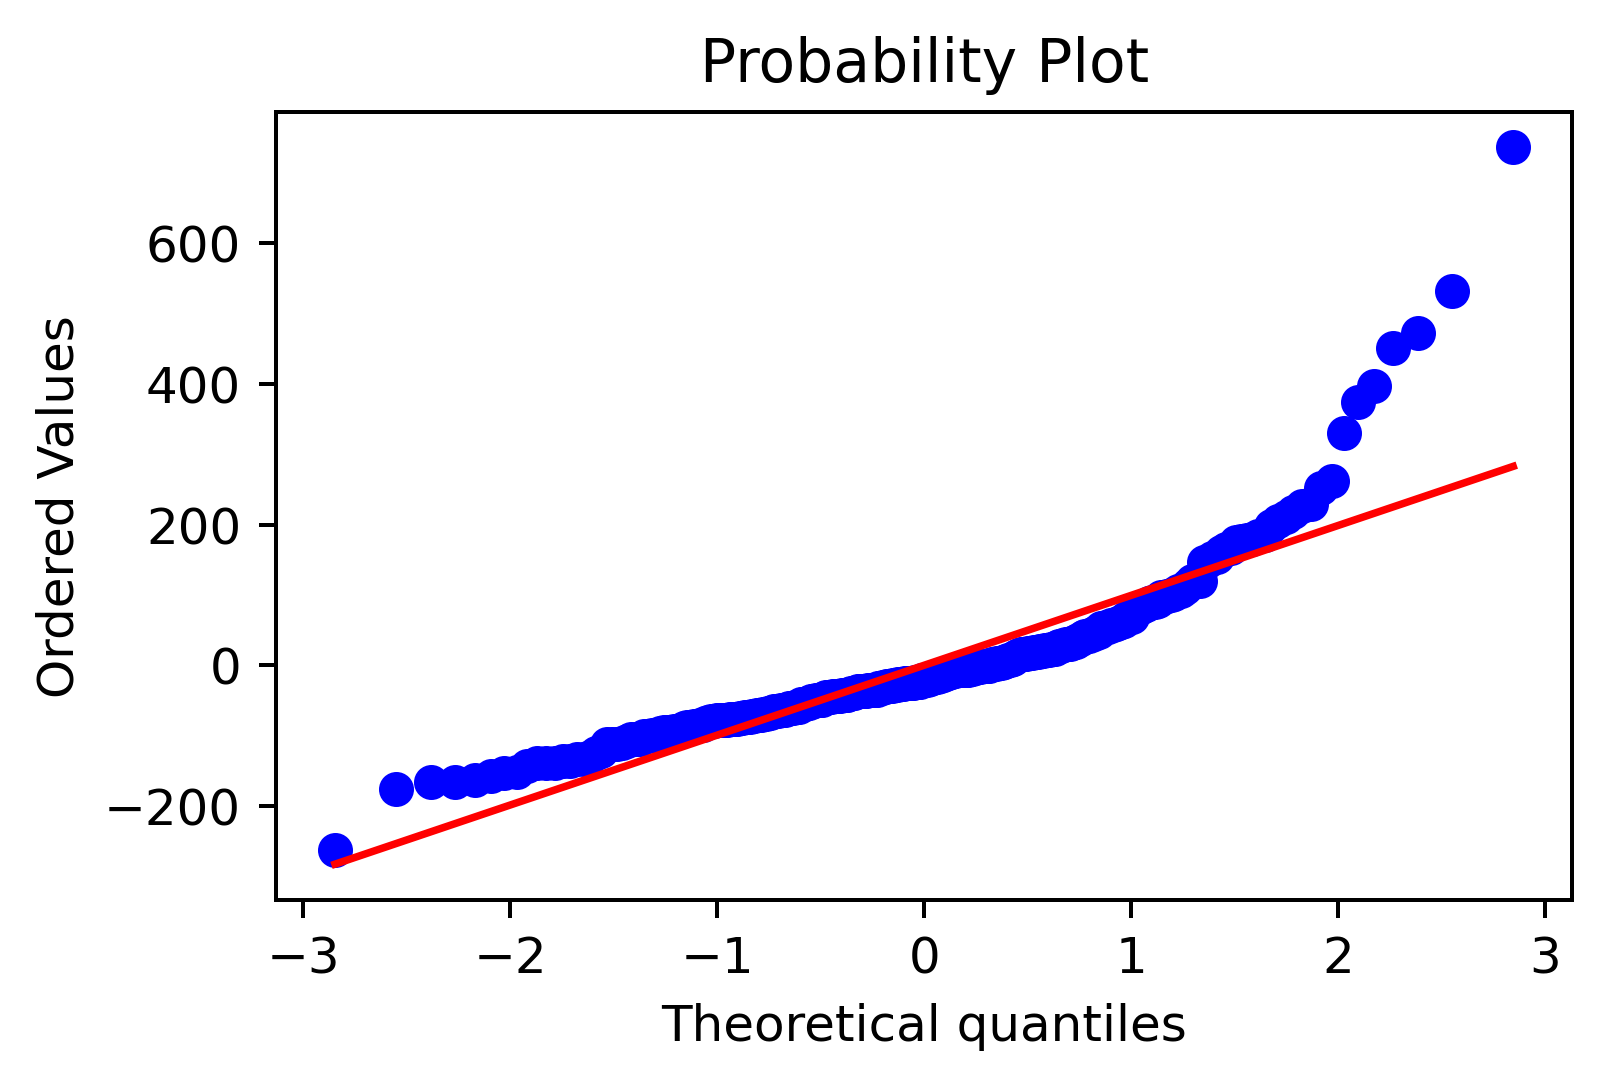

In [531]:
fig = plt.figure(figsize=(6,3))
headerfont = {'fontname':'Arial', 'fontsize':12}
plt.rcParams['figure.dpi'] = 360 # increase sharpness of chart
plt.gcf().subplots_adjust(bottom=0.15, left = 0.3)
ax = plt.subplot(111)
graph_DO = scipy.stats.probplot(OLS_SA2.resid, plot=plt)
plt.savefig('../plots/ptobplot.png')

only mean income seems to be significant for forecasting population

In [497]:
# NB_SA2.summary()

it seems that a OLS is more appropriate with only income as the only predictor

### testing

In this section we will be testing OLS and NB models through cross validation

In [498]:
# reset index
SA2_data.reset_index(inplace = True)

In [499]:
SA2_data.rename(columns = {'mean price':'mean_price', 'Median $ 2019': 'Median_income_2019','Mean $ 2019': 'Mean_income_2019', '2021 crime rate': 'crime_rate_2021'}, inplace = True)

In [500]:
# list to store error rates
OLS_error = []
NB_error = []

# we will perform a one part out cross validation 
for i in range(len(SA2_data)):
    # take out one part for testing
    test = SA2_data.iloc[[i],]
    # rest for training
    train = SA2_data[SA2_data.index !=i]
    
    # fit OLS model 
    OLS_income = ols(
       formula = "np.log(mean_price) ~ Mean_income_2019", data = train,
    family = families.NegativeBinomial()
        ).fit()
    # fit NB model
    NB_income =glm(
   formula = "np.log(mean_price) ~ Mean_income_2019", data = train,
    family = families.NegativeBinomial()
    ).fit()
    
    # output accuracy scores into pd frame '
    OLS_error.append(np.exp(float(OLS_income.predict(test))) - test['mean_price'])
    NB_error.append(np.exp(float(NB_income.predict(test))) - test['mean_price'])




/Users/lucyliu/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['family']
  warnings.warn(msg, ValueWarning)
/Users/lucyliu/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['family']
  warnings.warn(msg, ValueWarning)
/Users/lucyliu/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['family']
  warnings.warn(msg, ValueWarning)
/Users/lucyliu/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['family']
  warnings.warn(msg, ValueWarning)
/Users/lucyliu/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['family']
  warnings.warn(msg, ValueWarning)
/Users/lucyliu/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['family']
  warnings.warn(msg, ValueWarning)
/Users/luc

In [342]:
# create pandas frame to store results
Results_CV = pd.DataFrame()

# write results error in

Results_CV['OLS error'] = OLS_error
Results_CV['NB error'] = NB_error

In [343]:
# change all to absolute values
Results_CV['OLS error'] = abs(Results_CV['OLS error'])
Results_CV['NB error'] = abs(Results_CV['NB error'])

In [344]:
# examine the errors -OLS
# print('median of OLS errors is', Results_CV['OLS error'].median())
# print('sd of OLS errors is', Results_CV['OLS error'].std())

In [345]:
# examine NB errors
# print('median of NB errors is', Results_CV['NB error'].median())
# print('sd of NB errors is', Results_CV['NB error'].std())

the OLS model seems to be a better fit in this case, so we will use this for our forecasts

## Future data

In [346]:
# read in future data for income
future_income_data=pd.read_csv(main_directory+'data/curated/forecast_income_SA2.csv')

In [347]:
# future_income_data.sort_values(by = ['SA2_NAME'])

In [348]:
# SA2_data

In [349]:
SA2_data.reset_index(inplace = True)

In [350]:
SA2_data

,index,SA2 name,mean_price,median_price,SA2 code_y,pop_2021,Area,Children_population,Early_Working_age_population,Prime_Working_age_population,Mature_Working_age_population,Elderly_population,crime_rate_2021,SA2 CODE,Median_income_2019,Mean_income_2019
0,0,Abbotsford,572.679045,575.0,206071139.0,9262.0,1.7,759.0,905.0,6450.0,578.0,9832.0,0.118272,206071139.0,64090.0,78181.0
1,1,Airport West,409.000000,400.0,210011226.0,8237.0,3.7,1384.0,762.0,4102.0,797.0,9429.0,0.049673,210011226.0,58506.0,65204.0
2,2,Albert Park,700.882353,535.0,206051128.0,16023.0,4.7,2165.0,1470.0,8541.0,1731.0,18139.0,0.098302,206051128.0,67518.0,120412.0
3,3,Alexandra,350.000000,350.0,204011054.0,6768.0,2119.0,910.0,531.0,2601.0,1258.0,8236.0,0.043809,204011054.0,39452.0,48414.0
4,4,Alfredton,423.421053,420.0,201011001.0,16823.0,52.7,4075.0,2391.0,7550.0,1375.0,18255.0,0.063340,201011001.0,53932.0,63668.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,309,Yarram,327.500000,327.5,205051104.0,5556.0,1931.9,777.0,470.0,2122.0,1098.0,6645.0,0.070800,205051104.0,37232.0,48524.0
310,310,Yarraville,560.571429,540.0,213031352.0,15653.0,5.6,3024.0,1439.0,8874.0,1172.0,16797.0,0.081576,213031352.0,69410.0,83130.0
311,311,Yarrawonga,451.666667,495.0,216021414.0,8585.0,94.7,1364.0,752.0,2986.0,1367.0,10701.0,0.053705,216021414.0,41980.0,49703.0
312,312,Yarriambiack,307.500000,307.5,215011394.0,6454.0,7139.6,1015.0,586.0,2412.0,1105.0,7790.0,0.075221,215011394.0,44238.0,52472.0


In [351]:
# new df with only relevant data
SA2_data_relevant = pd.DataFrame()
SA2_data_relevant['SA2'] = SA2_data['SA2 name']
SA2_data_relevant['mean_price']=SA2_data['mean_price']

In [352]:
# merge df
future_income_data=future_income_data.merge(SA2_data_relevant, how = 'inner', left_on = 'SA2_NAME', right_on = 'SA2')

In [353]:
# future_income_data

In [354]:
# future_income_data

In [355]:
# future_income_data.dropna() # are there anymore NA values

In [356]:
# rename columns 
for i in range(2020,2026): 
    future_income_data=future_income_data.rename(columns = {str(i): 'Mean_income_' + str(i)})

In [357]:
# let's fit the model with the 2022 data
OLS_SA2_2022 = ols(
   formula = "mean_price ~ Mean_income_2021", data = future_income_data
).fit()

In [358]:
# OLS_SA2_2022.summary()

The R squared value is much lower when using supposedly current income data, this suggests that perhaps rental prices are adjusted at a slower rate than income ie. average income is refleceted years later in the rental prices, hence we will keep the model as it is where income 3 years ago is used to foreecast the most current years' prices of rent per SA2

## forecasting

In [36]:
SA2_data.rename(columns = {'Mean_income_2019': 'Mean_income'}, inplace = True) # rename to fit general model

In [37]:
# SA2_data

In [38]:
# create final model
OLS_final = ols(formula = 'mean_price ~ Mean_income', data = SA2_data).fit()

PatsyError: Error evaluating factor: NameError: name 'Mean_income' is not defined
    mean_price ~ Mean_income
                 ^^^^^^^^^^^

In [39]:
# OLS_final.summary()

In [40]:
# df to store predictions
Predictions = pd.DataFrame()
Predictions['SA2'] = future_income_data['SA2_NAME']
# predict for the next three years; iterative
for i in range(2023,2026): 
    df = pd.DataFrame()
    df['Mean_income'] = future_income_data['Mean_income_' +str(i)]
    Predictions[str(i)] = OLS_final.predict(df).astype(float)
    

    
    


NameError: name 'future_income_data' is not defined

In [364]:
#1. make new df to reflect current mean prices per SA2
current_rent = pd.DataFrame()
current_rent['SA2']=SA2_data['SA2 name']
current_rent['2022'] = SA2_data['mean_price']

In [365]:
# join current with future to allow comparisons
Predictions=pd.merge(Predictions, current_rent, left_on = ['SA2'], right_on = ['SA2'])

In [366]:
# get rate of change per year
for i in range(2022, 2025): 
    Predictions['Change from ' + str(i)+' to '+ str(i+1)] =  Predictions[str(i+1)] -  Predictions[str(i)]

In [367]:
# get total change
Predictions['total_change'] = (Predictions['Change from 2022 to 2023'] +Predictions['Change from 2023 to 2024']
                               +Predictions['Change from 2024 to 2025'])

In [368]:
# get average change
Predictions['average_change'] = Predictions['total_change']/3

In [369]:
Predictions.sort_values(by = ['average_change'], ascending = False,inplace = True) # sort by growth rate average

In [370]:
# get top ten suburbs
top_ten = Predictions.iloc[:10,]

In [371]:
# top_ten

In [372]:
# plot income change for top ten suburbs 
top_ten_income = future_income_data[future_income_data['SA2_NAME'].isin(list(top_ten['SA2']))]

In [373]:
# top_ten_income

In [374]:
# top_ten_income.T.iloc[2:5,].plot()

In [375]:
# sort values to be consistent -> join 2019 data to income data
SA2_data.sort_values(by = ['SA2 name'], inplace = True)
future_income_data.sort_values(by = ['SA2_NAME'], inplace = True)

In [376]:
future_income_data['Mean_income_2019'] = SA2_data['Mean_income']

In [377]:
# get change in income each year
for i in range(2019, 2025): 
    future_income_data['Change from ' + str(i)+' to '+ str(i+1)] = future_income_data['Mean_income_'+ str(i+1)] -  future_income_data['Mean_income_'+ str(i)]


In [378]:
# future_income_data

In [1]:
# predictions to csv
Predictions.to_csv(main_directory +'data/curated/predictions_in_order.csv')

NameError: name 'Predictions' is not defined